## Geometric characterisations of JEPA displacement field

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import umap as umap_module

from src.utils.io import MODEL_RUNS_BASE_DIR

%matplotlib inline

SEED = 42
rng  = np.random.default_rng(SEED)

In [3]:
model_tag = "test-64-config"
embeddings_tag = "embeddings_ep12.npz"

artifact_dir = MODEL_RUNS_BASE_DIR / model_tag
embeddings_path = artifact_dir / embeddings_tag
artifact_geo_dir = artifact_dir / "geometry"
artifact_geo_dir.mkdir(parents=True, exist_ok=True)

npz = np.load(embeddings_path, allow_pickle=True)
delta          = npz["delta"].astype(np.float64)
labels         = npz["labels"].astype(np.int32)
subject_ids    = npz["subject_ids"].astype(str)
mask_positions = npz["mask_positions"].astype(np.int64)

N, D  = delta.shape

## Displacement Field

In [12]:
from src.analysis.geometry import displacement_stats

In [13]:
norms  = np.linalg.norm(delta, axis=1)
norms0 = norms[(labels == 0)]
norms1 = norms[(labels == 1)]

mw_stat, mw_p = stats.mannwhitneyu(norms0, norms1, alternative="two-sided")
disp_stats = displacement_stats(delta, labels)

for k, s in disp_stats.items():
    print(f"{k:<20}{s}")

n_samples           418
n_label0            124
n_label1            294
norm_mean           1.7621205637138755
norm_mean_label0    1.7848582544393519
norm_mean_label1    1.7525305172854428
norm_std            0.3690049434779238
norm_min            1.3847212978469423
norm_median         1.6621605745745414
norm_max            3.80188168449652
mannwhitney_stat    14595.0
mannwhitney_p       0.0012836025877452264


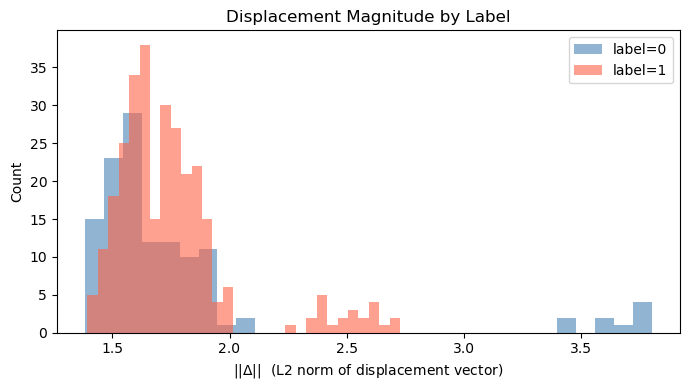

In [4]:
colors = {0: "steelblue", 1: "tomato"}

# -- histogram --
fig, ax = plt.subplots(figsize=(7, 4))
for lbl, col in colors.items():
    vals = norms[labels == lbl]
    ax.hist(vals, bins=30, alpha=0.6, color=col, label=f"label={lbl}")
ax.set_xlabel(r"||$\Delta$||  (L2 norm of displacement vector)")
ax.set_ylabel("Count")
ax.set_title("Displacement Magnitude by Label")
ax.legend()
fig.tight_layout()
# fig.savefig(artifact_geo_dir / "hist_delta_norm.png", dpi=150)

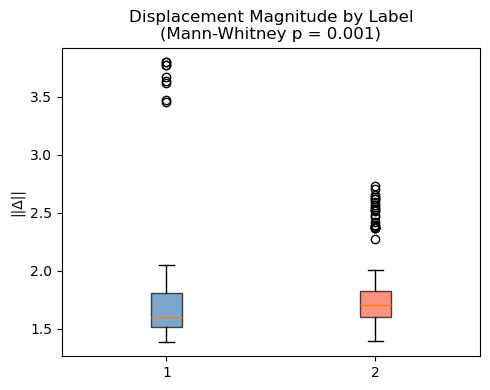

In [5]:
fig, ax = plt.subplots(figsize=(5, 4))
grouped = [
    (norms[labels == lbl], lbl) 
    for lbl in [0, 1] if (labels == lbl).any()
]

bp = ax.boxplot(
    [d for d, _ in grouped],
    label=[f"label={lbl}" for _, lbl in grouped],
    patch_artist=True,
)
for patch, (_, lbl) in zip(bp["boxes"], grouped):
    patch.set_facecolor(colors[lbl])
    patch.set_alpha(0.7)
p_str = f"{mw_p:.3f}" if not np.isnan(mw_p) else "n/a"
ax.set_ylabel("||Δ||")
ax.set_title(f"Displacement Magnitude by Label\n(Mann-Whitney p = {p_str})")
fig.tight_layout()
# fig.savefig(artifact_geo_dir / "box_delta_norm.png", dpi=150)

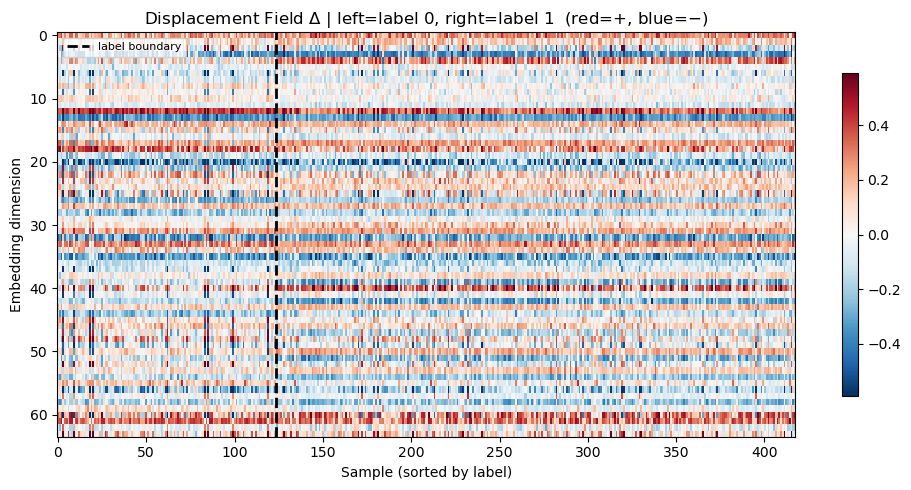

In [6]:
# heatmap (sorted by label)
sort_idx     = np.argsort(labels)
delta_sorted = delta[sort_idx]
n_neg        = int((labels[sort_idx] == 0).sum())
vmax = float(np.percentile(np.abs(delta_sorted), 99)) or 1.0

fig, ax = plt.subplots(figsize=(10, 5))
im = ax.imshow(
    delta_sorted.T, aspect="auto", cmap="RdBu_r",
    vmin=-vmax, vmax=vmax, interpolation="nearest",
)
ax.axvline(n_neg - 0.5, color="black", linewidth=2, linestyle="--",
            label="label boundary")
ax.set_xlabel("Sample (sorted by label)")
ax.set_ylabel("Embedding dimension")
ax.set_title(r"Displacement Field $\Delta$ | left=label 0, right=label 1  (red=+, blue=−)")
plt.colorbar(im, ax=ax, shrink=0.8)
ax.legend(loc="upper left", fontsize=8)
fig.tight_layout()
# fig.savefig(artifact_geo_dir / "heatmap_delta.png", dpi=150)

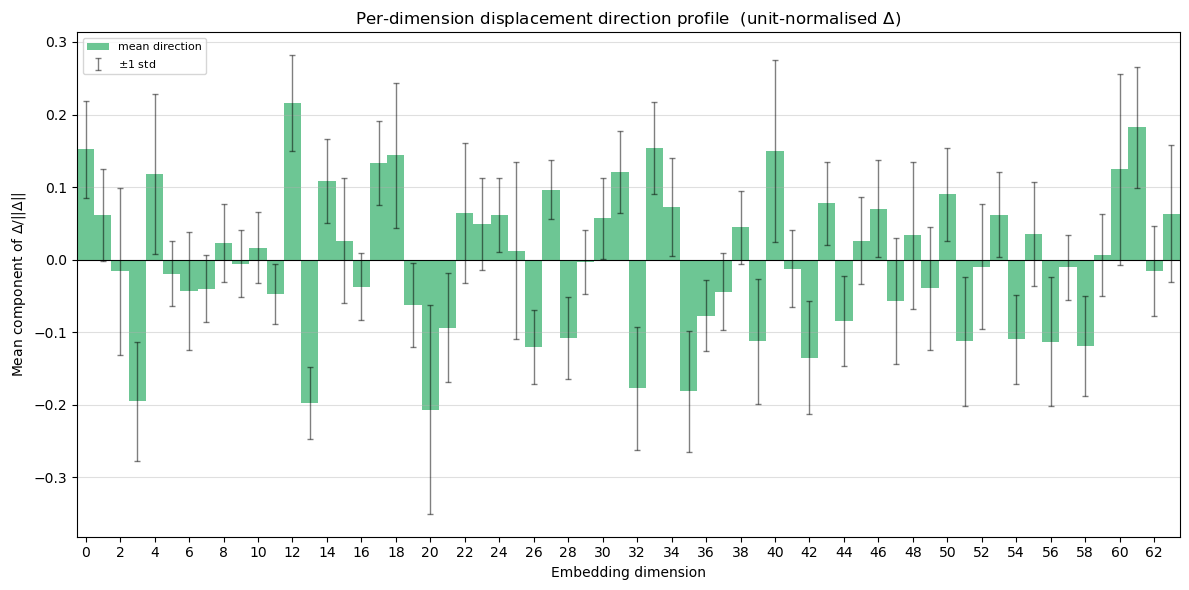

In [7]:
# per-dimension norme'd direction
safe_norms        = norms[:, np.newaxis].copy()
safe_norms[safe_norms < 1e-10] = 1e-10
delta_normed      = delta / safe_norms # unit vectors
dim_mean          = delta_normed.mean(axis=0)
dim_std           = delta_normed.std(axis=0)
D                 = delta.shape[1]

fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(D)
ax.bar(x, dim_mean, color="mediumseagreen", alpha=0.75, label="mean direction", width=1.0)
ax.errorbar(x, dim_mean, yerr=dim_std, fmt="none", ecolor="black",
            elinewidth=1.0, capsize=2, alpha=0.5, label=r"$\pm$1 std")
ax.axhline(0, color="black", linewidth=0.8)
ax.set_xlabel("Embedding dimension", fontsize=10)
ax.set_xlim(-0.5, D-0.5)
ax.set_xticks(np.arange(0, D, 2))
ax.set_ylabel(r"Mean component of $\Delta$/||$\Delta$||")
ax.set_title(r"Per-dimension displacement direction profile  (unit-normalised $\Delta$)")
ax.legend(fontsize=8)
fig.tight_layout()
ax.grid(True, axis="y", alpha=0.4)
# fig.savefig(artifact_geo_dir / "dim_profile.png", dpi=150)

## PCA

Fit full PCA on the displacement field.

Uses $n_{components} = D$ so complete eigenvalue spectrum is available for the scree plot and Marchenko-Pastur comparison.

In [14]:
from src.analysis.geometry import fit_pca_stats

In [15]:
top_k = 10
top_k = min(top_k, D, N - 1)

pca, pca_projection, pca_stats = fit_pca_stats(delta, top_k, n_samples=N)

for k, s in pca_stats.items():
    print(f"{k:<30}{s}")

n_samples                     418
n_components                  64
top_k                         10
n_signal_components           4
mp_upper_bound                0.04072056255404348
effective_dimensionality      2.6025822067142266
components_for_90pct          8
components_for_95pct          16
top_k_explained_variance      0.9200794152760758
eigenvalues_all               [0.7978501960335427, 0.2276880875341751, 0.055120458726218506, 0.04896287765427055, 0.0280713648250395, 0.02198043922603711, 0.02025158683100141, 0.014742585087102298, 0.013138373708606406, 0.010939240638237957, 0.008433458608920086, 0.008210631334704671, 0.006808675101795706, 0.0064725568175666255, 0.005639192514894933, 0.005271015762581204, 0.0045575994141688276, 0.004428620877801161, 0.0037358703159058575, 0.0035978367810551477, 0.003328172395040082, 0.0032772939597388263, 0.0030093025661982243, 0.002706728161900326, 0.002516302276822925, 0.002398955516796438, 0.002326450134566938, 0.002215089405584859, 0.002093751

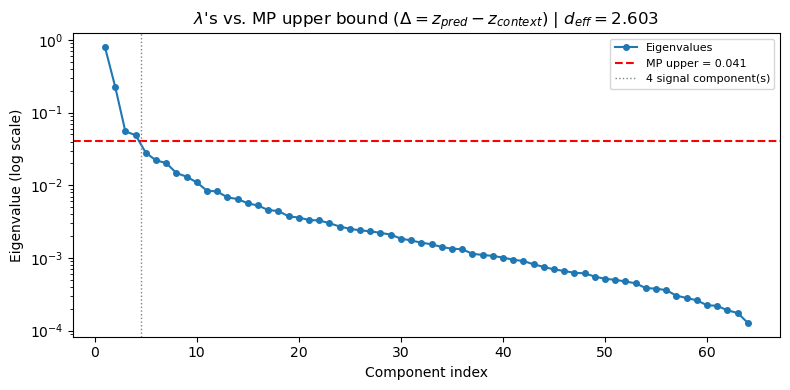

In [24]:
mp_upper = pca_stats['mp_upper_bound']
n_signal = pca_stats['n_signal_components']
d_eff_str = f"{pca_stats['effective_dimensionality']:.3f}"
eigenvalues  = pca.explained_variance_

# Scree plot
fig, ax = plt.subplots(figsize=(8, 4))
ax.semilogy(range(1, D + 1), eigenvalues, "o-", markersize=4, label="Eigenvalues")
ax.axhline(mp_upper, color="red", linestyle="--", linewidth=1.5,
            label=f"MP upper = {mp_upper:.3f}")
if n_signal > 0:
    ax.axvline(n_signal + 0.5, color="gray", linestyle=":", linewidth=1,
                label=f"{n_signal} signal component(s)")
ax.set_xlabel("Component index")
ax.set_ylabel("Eigenvalue (log scale)")
ax.set_title(r"$\lambda$'s vs. MP upper bound ($\Delta = z_{pred} - z_{context}$) | $d_{eff} = $" + d_eff_str)
ax.legend(fontsize=8)
fig.tight_layout()
# fig.savefig(artifact_geo_dir / "scree_plot.png", dpi=150)

### ^^ The displacement field is low rank ^^

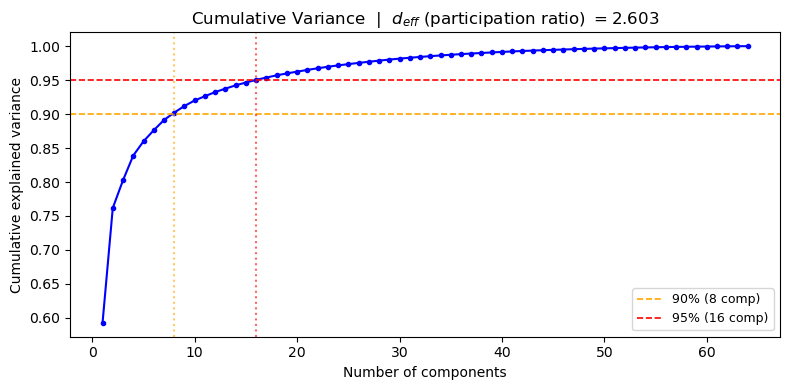

In [26]:
evr          = pca.explained_variance_ratio_
cumvar       = np.cumsum(evr)

thresh90 = int(np.searchsorted(cumvar, 0.90)) + 1
thresh95 = int(np.searchsorted(cumvar, 0.95)) + 1
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(range(1, D + 1), cumvar, "b-o", markersize=3)
ax.axhline(0.90, color="orange", linestyle="--", linewidth=1.2, label=f"90% ({thresh90} comp)")
ax.axhline(0.95, color="red",    linestyle="--", linewidth=1.2, label=f"95% ({thresh95} comp)")
ax.axvline(thresh90, color="orange", linestyle=":", alpha=0.6)
ax.axvline(thresh95, color="red",    linestyle=":", alpha=0.6)
ax.set_xlabel("Number of components")
ax.set_ylabel("Cumulative explained variance")
ax.set_title(r"Cumulative Variance  |  $d_{eff}$ (participation ratio) $= $" + d_eff_str)
ax.legend(fontsize=9)
fig.tight_layout()
# fig.savefig(artifact_geo_dir / "cumulative_variance.png", dpi=150)

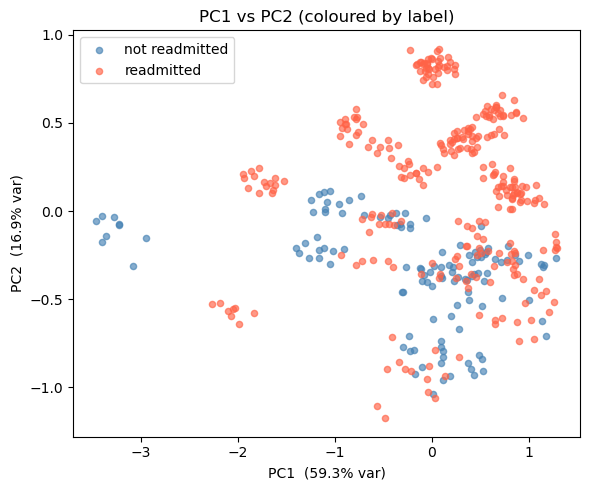

In [28]:
fig, ax = plt.subplots(figsize=(6, 5))
for lbl, col in [(0, "steelblue"), (1, "tomato")]:
    mask = labels == lbl
    if mask.any():
        ax.scatter(pca_projection[mask, 0], pca_projection[mask, 1],
                    c=col, label="readmitted" if lbl == 1 else "not readmitted", alpha=0.65, s=20)
ax.set_xlabel(f"PC1  ({evr[0]:.1%} var)")
ax.set_ylabel(f"PC2  ({evr[1]:.1%} var)" if D > 1 else "PC2")
ax.set_title("PC1 vs PC2 (coloured by label)")
ax.legend()
fig.tight_layout()
# fig.savefig(artifact_geo_dir / "pc1_pc2_label.png", dpi=150)

### ^^ The geometry of the latent displacement encodes readmission risk without ever being trained on it ^^

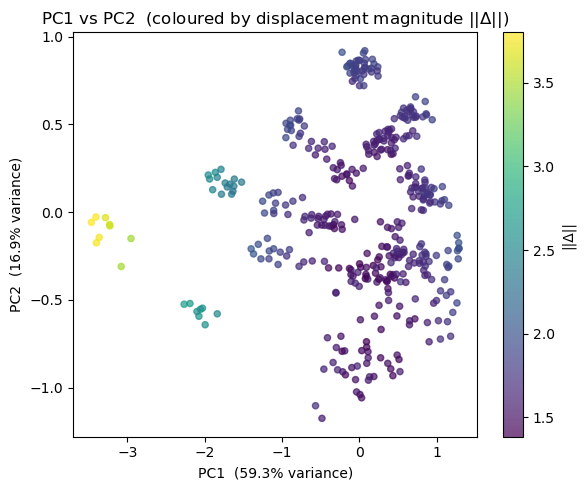

In [30]:
fig, ax = plt.subplots(figsize=(6, 5))
sc = ax.scatter(pca_projection[:, 0], pca_projection[:, 1],
                c=norms, cmap="viridis", alpha=0.7, s=20)
plt.colorbar(sc, ax=ax, label="||Δ||")
ax.set_xlabel(f"PC1  ({evr[0]:.1%} variance)")
ax.set_ylabel(f"PC2  ({evr[1]:.1%} variance)")
ax.set_title(r"PC1 vs PC2  (coloured by displacement magnitude ||$\Delta$||)")
fig.tight_layout()
# fig.savefig(artifact_geo_dir / "pc1_pc2_norm.png", dpi=150)

- far-left cluster (PC1 ≈ −3.5) with small displacement magnitudes is a subpopulation where the predictor's output closely matches the context encoder - the model finds these patients "easy to predict."
- main cloud has larger magnitudes, which have larger prediction errors 

Suggests the model partitions patients into "predictable" vs. "less predictable" subgroups.

**combining this with Image 4, the predictable cluster skews toward non-readmitted**. Supports narrative that patients the model struggles to predict (large \|$\Delta$\|) may be the ones at higher clinical risk.

In [35]:
np.save(artifact_geo_dir / "pca_projections.npy", pca_projection)

## UMAP

In [16]:
from src.analysis.geometry import fit_umap_2d

In [17]:
n_neighbors = 10    # Keep >= 10

umap_embedding = fit_umap_2d(delta, n_neighbors=n_neighbors, seed=SEED)
print(f"  shape={umap_embedding.shape}")

c:\Users\tanne\.conda\envs\chronos-lens\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  shape=(418, 2)


In [18]:
np.save(artifact_geo_dir / "umap_embedding.npy", umap_embedding)

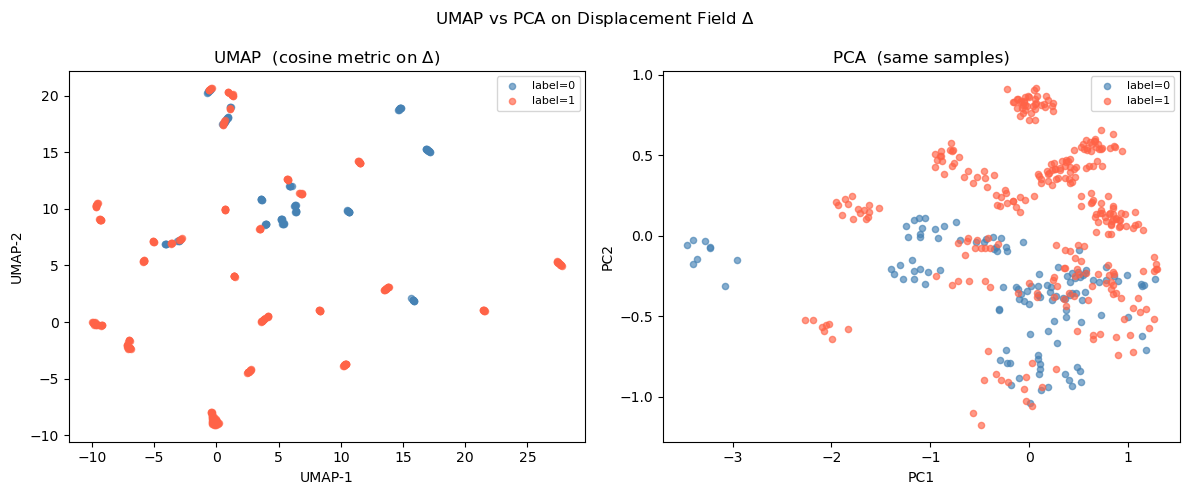

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for lbl, col in [(0, "steelblue"), (1, "tomato")]:
    mask = labels == lbl
    if mask.any():
        axes[0].scatter(umap_embedding[mask, 0], umap_embedding[mask, 1],
                        c=col, label=f"label={lbl}", alpha=0.65, s=20)
        axes[1].scatter(pca_projection[mask, 0], pca_projection[mask, 1],
                        c=col, label=f"label={lbl}", alpha=0.65, s=20)
axes[0].set_title(r"UMAP  (cosine metric on $\Delta$)")
axes[0].set_xlabel("UMAP-1")
axes[0].set_ylabel("UMAP-2")
axes[0].legend(fontsize=8)
axes[1].set_title("PCA  (same samples)")
axes[1].set_xlabel("PC1")
axes[1].set_ylabel("PC2")
axes[1].legend(fontsize=8)
fig.suptitle(r"UMAP vs PCA on Displacement Field $\Delta$")
fig.tight_layout()
# fig.savefig(artifact_geo_dir / "umap_vs_pca.png", dpi=150)

- label separation mixed.
- UMAP revealing more local cluster structure that PCA's linear projection misses, does this suggest there are nonlinear manifold patterns in the displacement field

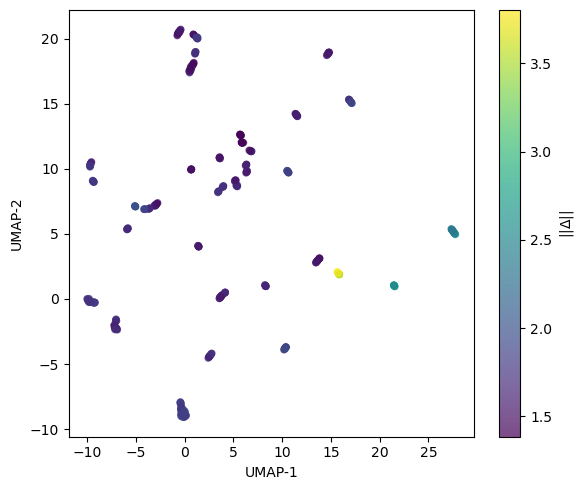

In [34]:
# -- coloured by displacement magnitude --
fig, ax = plt.subplots(figsize=(6, 5))
sc = ax.scatter(umap_embedding[:, 0], umap_embedding[:, 1],
                c=norms, cmap="viridis", alpha=0.7, s=20)
plt.colorbar(sc, ax=ax, label=r"||$\Delta$||")
ax.set_xlabel("UMAP-1")
ax.set_ylabel("UMAP-2")
fig.tight_layout()
# fig.savefig(artifact_geo_dir / "umap_norm.png", dpi=150)